In [ ]:
import glob, os, sys
import re
import itertools

import pandas as pa
import numpy as np
import pylab as plt

MIN_ITERATIONS = 2
SHOW_FIGURES = True
PLOT_TYPE="pgf" # pgf

# configure visuals
markers=['o', 's', 'd', 'D', "*", "o"]
linestyles=['-', '--', ':', '-.', "-", "--"]
colors = ["#ff0000", "#008000", "#000080", "#000000", "#800080", "#008080"]

def extractWTime(line):
    value = line.replace("Elapsed (wall clock) time (h:mm:ss or m:ss): ", "")
    res = re.match(r"\s*((\d+)h )?(\d+)m (\d+(\.\d+)?)s", value)
    if (res):
        hours, minutes, seconds, _ = [float(x) for x in res.groups(0)[1:]]
        return (3600.0 * hours + 60.0 * minutes + seconds)

    fields = [float(x) for x in value.split(":")]
    assert(len(fields) <= 3)
    while (len(fields) < 3):
        fields = [0.0] + fields
    return fields[0] * 3600 + fields[1] * 60 + fields[2]

def extractNum(str, t="int"):
    if (t == "float"):
        res=re.search(r"[\s=](\d\.\d+e[+\-]\d+)", str)
        if (res):
            return float(res.groups()[0])


    nums = [s for s in str.replace(")"," ").replace("="," ").replace("ms", "").split() if s.replace('.','').isdigit()]
    if not nums:
        return None

    assert(len(nums) == 1)

    num = nums[0]

    if "." in num or t == "float":
        return float(num)
    else:
        return int(num)

def insertUnique(di, key, value):
    assert(not key in di)
    di[key] = value
    
def algoLabel(algo, force=False):
    if SHOW_FIGURES and not force: return algo
    if type(algo) is str: return "\\" + algo
    return ["\\" + x for x in algo]

# parse log-files in ../data directory
def loadLogs(path="./runtime/"):
    files = glob.glob(path + "*/*/*.log")

    logs = []
    for file in files:
        fn = os.path.basename(file)

        row = {
            'group': file.split('/')[-3],
            'file': file
        }

        with open(file, "r") as fh:
            try:
                for line in fh:
                    if "conf.nodes:" in line or "-n No. Nodes" in line or "generate graph (n=" in line:
                        insertUnique(row, "nodes", extractNum(line))
                        row['algo'] = 'hypgen'
                        
                        if "phi" in row["group"]:
                            row['algo'] += " (Phi)"
                            
                        if "skipdist" in row["group"]:
                            row['algo'] += " (Skip Dist.)"
                        
                    elif "conf.avgDegree:" in line or "-d Avg. Degree" in line or " d=" in line:
                        row["deg"] = extractNum(line)
                    elif "conf.degreeExp:" in line or "-e Distr. Exp" in line or " gamma=" in line:
                        insertUnique(row, "exp", extractNum(line, "float"))
                        row["exp"] = int(10.0*row["exp"] + 0.5)
                    elif "conf.noSegments:" in line:
                        insertUnique(row, "segs", extractNum(line))
                    elif "conf.noWorker:" in line or " p=" in line:
                        insertUnique(row, "worker", extractNum(line))
                    elif "TargetRadius: " in line:
                        insertUnique(row, "R", extractNum(line, "float"))
                    elif "Number of edges: " in line:
                        insertUnique(row, "edges", extractNum(line))
                    elif "Number of compares: " in line or "Compares: " in line:
                        insertUnique(row, "compares", extractNum(line))
                    elif "Generator time Time elapsed" in line:
                        insertUnique(row, "gtime", extractNum(line, "float"))

                    elif "[INFO ]: Produced " in line and " edges" in line:
                        insertUnique(row, "edges", extractNum(line))
                    elif "[INFO ]: Required " in line and " compares" in line:
                        insertUnique(row, "compares", extractNum(line.split("compares")[0]))
                    elif "Timer Time elapsed" in line:
                        insertUnique(row, "gtime", extractNum(line, "float"))

                    elif " time=" in line:
                        insertUnique(row, "gtime", extractNum(line, "float")*1000)
                    elif " edges=" in line:
                        insertUnique(row, "edges", int(extractNum(line, "float")))
                    elif " compares_per_edge=" in line:
                        row['algo'] = 'rhg'
                        insertUnique(row, "compares", int(row["edges"] * extractNum(line, "float")))

                    elif "Generated " and " edges" in line:
                        insertUnique(row, "edges",  extractNum(line))
                    elif "Avg. Deg " in line:
                        insertUnique(row, "deg",  extractNum(line, "float"))
                    elif "gen Time elapsed:" in line:
                        insertUnique(row, "gtime", extractNum(line, "float"))

                    elif "Maximum resident set size (kbytes):" in line:
                        if "ressize" in row:
                            row["ressize"] += extractNum(line)
                            row["ressize_count"] += 1
                        else:    
                            insertUnique(row, "ressize", extractNum(line))
                            row["ressize_count"] = 1
                            
                    elif False and "Elapsed (wall clock) time (h:mm:ss or m:ss):" in line:
                        if "wtime" in row:
                            row["wtime"] = np.max(row["wtime"], extractWTime(line))
                        else:
                            insertUnique(row, "wtime", extractWTime(line))

                    elif "[INFO ]: Start Original" in line:
                        row['algo'] = "nkgen"
                    elif "[INFO ]: Start Opt" in line:
                        row['algo'] = "nkgenopt"
                    elif "../related_work/girg/embedder" in line:
                        row['nodes'] = int(row['edges'] / row['deg'] * 2 + 0.5)
                        if   8 < row['deg'] < 12: row['deg'] = 10
                        if 980 < row['deg'] < 1020: row['deg'] = 1000

                        assert(row['nodes'] > 100)
                        row['algo'] = "girggen"
            except:
                print("Could not parse " + file)
                continue


        if not "gtime" in row:
            print("Skip '%s' as it seems incomplete" % file)
            continue

        if not "compares" in row:
            row["compares"] = 0
            
        if "RHG" == row["algo"] and row["worker"] == 8:
            continue
            
        if "ressize_count" in row and row["ressize_count"] > 1:
            row["ressize"] *= 16 / row["ressize_count"]
            
            
        if "HypEmbdr" == row["algo"]:
            row["gtime"] /= 1

        if row["edges"]:
            row["compEdge"] = float(row["compares"]) / float(row["edges"])

        if row["nodes"]:
            row["effDeg"] = float(row["edges"]) / float(row["nodes"]) * 2.0
            
        logs.append(row)

    if not logs:
        return []

    data = pa.DataFrame(logs)
    print("Gathered %d files from %d groups" % (len(row), len(data.group.unique())) )
    return data

def latexFriendlyPlot(fig_width_pt = 246.0, ratio=(5**0.5-1.0)/2.0):
    # Get fig_width_pt from LaTeX using \showthe\columnwidth
    inches_per_pt = 1.0/72.27               # Convert pt to inch
    fig_width = fig_width_pt*inches_per_pt  # width in inches
    fig_height = fig_width*ratio      # height in inches
    fig_size =  [fig_width,fig_height]
    params = {#'backend': 'ps',
              'axes.labelsize': 10,
              'font.size': 10,
              'legend.fontsize': 9,
              'xtick.labelsize': 10,
              'ytick.labelsize': 10,
              'text.usetex': True,
              'text.latex.unicode': True,
              'figure.figsize': fig_size,
              "font.family": "serif",
              "font.serif": [],
              "pgf.preamble": [
                  r"\usepackage[utf8x]{inputenc}",
                  r"\usepackage[T1]{fontenc}",
                  r"\newcommand{\nkgen}{\textsc{NkGen}}",
                  r"\newcommand{\nkgenopt}{\textsc{NkGenOpt}}",
                  r"\newcommand{\hypgen}{\textsc{HyperGen}}",
                  r"\newcommand{\memgen}{\textsc{MemGen}}",
                  r"\newcommand{\girggen}{\textsc{GirgGen}}",
                  r"\newcommand{\rhg}{\textsc{RHypGen}}"                     
              ]
              }
    plt.rcParams.update(params)

print("Load Logs")
data = loadLogs("../data/")
if (0 == len(data)):
    print("No valid data gathered. Did you execute this script from WITHIN")
    print("the folder experiments?")
    sys.exit(-1)

try: os.mkdir("results")
except: pass

--------------------------------------------------------------------------------
['girggen', 'rhg', 'nkgen', 'nkgenopt', 'hypgen', 'hypgen (Phi)']
Skip 3 of 16 groups as they include too few entries
Skip 3 of 16 groups as they include too few entries
Deg: 10, Exp: 3.0 nodes ressize
results/plot_ressize_d10_e30_abs.pgf


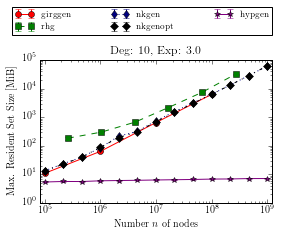

--------------------------------------------------------------------------------
['girggen', 'rhg', 'nkgen', 'nkgenopt', 'hypgen']
Deg: 10, Exp: 2.1 nodes ressize
results/plot_ressize_d10_e21_abs.pgf


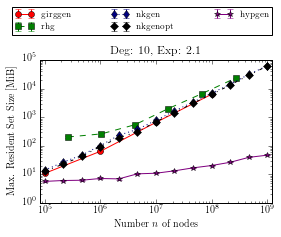

--------------------------------------------------------------------------------
['girggen', 'rhg', 'nkgen', 'nkgenopt', 'hypgen', 'hypgen (Phi)']
Deg: 1000, Exp: 3.0 nodes ressize
results/plot_ressize_d1000_e30_abs.pgf


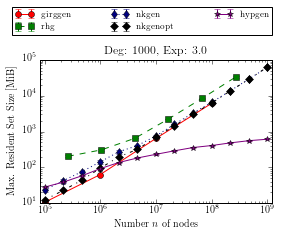

--------------------------------------------------------------------------------
['girggen', 'rhg', 'nkgen', 'nkgenopt', 'hypgen']
Deg: 1000, Exp: 2.1 nodes ressize
results/plot_ressize_d1000_e21_abs.pgf


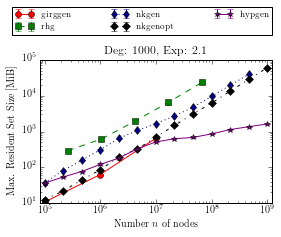

--------------------------------------------------------------------------------
['girggen', 'rhg', 'nkgen', 'nkgenopt', 'hypgen', 'hypgen (Phi)']
Skip 3 of 16 groups as they include too few entries
Skip 3 of 16 groups as they include too few entries
Deg: 10, Exp: 3.0 edges gtime
results/plot_gtime_d10_e30_abs.pgf


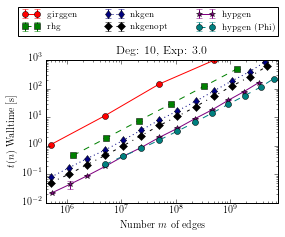

--------------------------------------------------------------------------------
['girggen', 'rhg', 'nkgen', 'nkgenopt', 'hypgen']
Deg: 10, Exp: 2.1 edges gtime
results/plot_gtime_d10_e21_abs.pgf


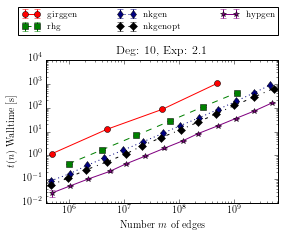

--------------------------------------------------------------------------------
['girggen', 'rhg', 'nkgen', 'nkgenopt', 'hypgen', 'hypgen (Phi)']
Deg: 1000, Exp: 3.0 edges gtime
results/plot_gtime_d1000_e30_abs.pgf


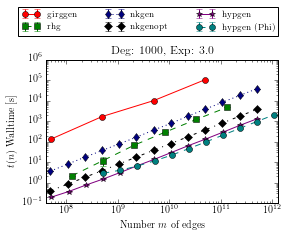

--------------------------------------------------------------------------------
['girggen', 'rhg', 'nkgen', 'nkgenopt', 'hypgen']
Deg: 1000, Exp: 2.1 edges gtime
results/plot_gtime_d1000_e21_abs.pgf


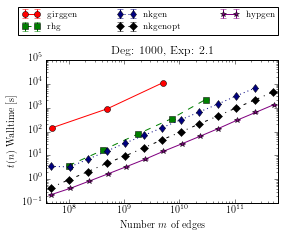

--------------------------------------------------------------------------------
['girggen', 'rhg', 'nkgen', 'nkgenopt', 'hypgen', 'hypgen (Phi)']
Skip 3 of 16 groups as they include too few entries
Skip 3 of 16 groups as they include too few entries
Deg: 10, Exp: 3.0 nodes ressize
results/plot_ressize_d10_e30_rel.pgf


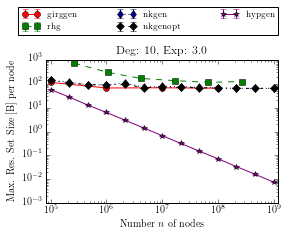

--------------------------------------------------------------------------------
['girggen', 'rhg', 'nkgen', 'nkgenopt', 'hypgen']
Deg: 10, Exp: 2.1 nodes ressize
results/plot_ressize_d10_e21_rel.pgf


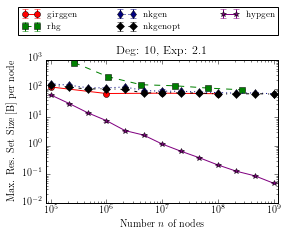

--------------------------------------------------------------------------------
['girggen', 'rhg', 'nkgen', 'nkgenopt', 'hypgen', 'hypgen (Phi)']
Deg: 1000, Exp: 3.0 nodes ressize
results/plot_ressize_d1000_e30_rel.pgf


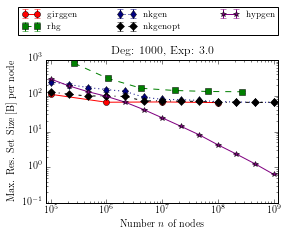

--------------------------------------------------------------------------------
['girggen', 'rhg', 'nkgen', 'nkgenopt', 'hypgen']
Deg: 1000, Exp: 2.1 nodes ressize
results/plot_ressize_d1000_e21_rel.pgf


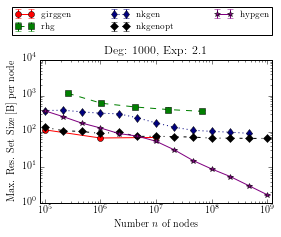

--------------------------------------------------------------------------------
['girggen', 'rhg', 'nkgen', 'nkgenopt', 'hypgen', 'hypgen (Phi)']
Skip 3 of 16 groups as they include too few entries
Skip 3 of 16 groups as they include too few entries
Deg: 10, Exp: 3.0 edges gtime
results/plot_gtime_d10_e30_rel.pgf


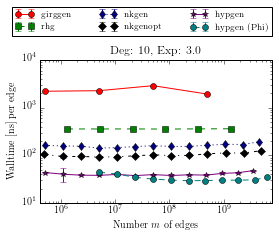

--------------------------------------------------------------------------------
['girggen', 'rhg', 'nkgen', 'nkgenopt', 'hypgen']
Deg: 10, Exp: 2.1 edges gtime
results/plot_gtime_d10_e21_rel.pgf


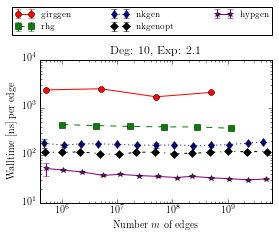

--------------------------------------------------------------------------------
['girggen', 'rhg', 'nkgen', 'nkgenopt', 'hypgen', 'hypgen (Phi)']
Deg: 1000, Exp: 3.0 edges gtime
results/plot_gtime_d1000_e30_rel.pgf


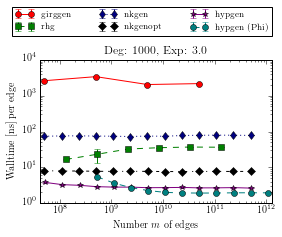

--------------------------------------------------------------------------------
['girggen', 'rhg', 'nkgen', 'nkgenopt', 'hypgen']
Deg: 1000, Exp: 2.1 edges gtime
results/plot_gtime_d1000_e21_rel.pgf


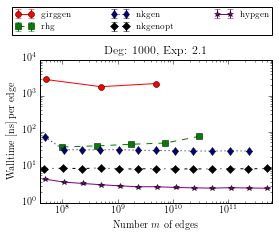

In [2]:
def sortAlgos(algos):
    algos = set(algos)
    result = []
    
    for o in ["girg", "rhg", "nkgen", "nkgenopt", "hypgen"]:
        matches = []
        for i in algos:
            if o in i:
                matches.append(i)
        algos = algos.difference(matches)
        result += sorted(matches)
    
    assert(0 == len(algos))
    print(result)
    return result

# Plot runtime/memory consumption as function of number of nodes/edges
# Also extract information for speed-up table
def comparePlots(data, relative, enable_plots = True):
    latexFriendlyPlot(300)
    exps = data["exp"].unique()
    degs = data["deg"].unique()
    exps = [30, 21]
    degs = [10, 1000]

    if relative:
        objectives = {
            "ressize": ("Max. Res. Set Size [B] per node", 2**10, "nodes")
            ,"gtime": ("Walltime [ns] per edge ", 1e6, "edges")
                      }
    else:
        objectives = {
            "gtime": ("$t(n)$ Walltime [s]", 1e-3, "edges")
            ,"ressize": ("Max. Resident Set Size [MiB]", 2.0**-10, "nodes")}

    avg_rows = []
    for obj, (ylabel, yscale, xkey) in objectives.items():
        for (deg, dexp) in itertools.product(degs, exps):
            plot_data = data.loc[(data["deg"]==deg)&(data["exp"] == dexp)]

            print('-' * 80)

            if enable_plots:
                fig = plt.figure(1)
                plt.clf()

                plt.axes([0.125,0.2,0.95-0.125,0.95-0.2])
                ax = plt.subplot()
                ax.set_xscale("log", nonposx='clip')
                ax.set_yscale("log", nonposy='clip')

            minx=1e100
            maxx=1

            for (algo, ls, col, mark) in zip(sortAlgos(plot_data["algo"].unique()), linestyles, colors, markers):
                if "ressize" == obj and "Phi" in algo:
                    continue

                try:
                    grp = plot_data[plot_data["algo"] == algo].groupby("nodes")
                    min_iters = MIN_ITERATIONS if 'hypgen' in algo or 'nkgen' in algo else 1
                    
                    mask = (grp.size() >= min_iters)
                    if (not np.all(mask)):
                        print("Skip %d of %d groups as they include too few entries" % (np.sum(np.invert(mask)), len(mask)))
                    if not np.any(mask):
                        print("Skip %s as all %d groups contain too few entries" % (algo, len(mask)))
                        continue


                    if xkey == "nodes":
                        xparam = grp["nodes"].median()[mask]
                    else:
                        xparam = grp.median()[xkey][mask]

                    minx = min(minx, np.min(xparam))
                    maxx = max(maxx, np.max(xparam[mask]))

                    obj_mean = grp.median()[obj][mask] * yscale
                    obj_err  = np.array(list(grp.std()[obj][mask] * yscale))

                    if relative:
                        obj_mean /= xparam
                        obj_err /= xparam

                        mean_mask = (xparam >= (9e7 * deg))

                        if (obj == "gtime"):
                            avg_rows.append ({
                                'algo': algo,
                                'xkey': xkey,
                                'exp': dexp,
                                'deg': deg,
                                'edgetime_mean': np.mean(obj_mean[mean_mask]),
                                'edgetime_std': np.std(obj_mean[mean_mask])
                            })

                    obj_err[np.isnan(obj_err)] = 0.0
                    
                    if enable_plots:
                        plt.errorbar(xparam, obj_mean, yerr=obj_err, label=algoLabel(algo),
                                     ls=ls, color=col, marker=mark, markersize=6)
                except Exception as e:
                    print(str(e), algo, plot_data[plot_data["algo"] == algo])
                    pass

            title = "Deg: %d, Exp: %.1f" % (deg, dexp/10.0)
            print(title, xkey, obj)

            if enable_plots:
                if (False and obj == "ressize"):
                    plt.axhline(2**10 * 64)
                plt.title(title)
                plt.xlabel("Number $n$ of nodes" if xkey == "nodes" else "Number $m$ of edges")
                plt.ylabel(ylabel)
                ax.set_xlim([minx/1.2, maxx * 1.2 ])

            fn = 'results/plot_%s_d%d_e%d_%s.%s' % (obj, deg, dexp, "rel" if relative else "abs", PLOT_TYPE)
            if not fn in ["plot_gtime_d1000_e30_rel.pgf", "plot_ressize_d1000_e30_rel.pgf"]:
                plt.legend(loc="best", ncol=3, mode="expand", bbox_to_anchor=(-0.14, 1.4, 1.16, 0))

            print(fn)

            if enable_plots:
                if SHOW_FIGURES:
                    plt.show()
                else:
                    plt.savefig(fn, transparnt=True, bbox_inches="tight")
                        

    return pa.DataFrame(avg_rows)

comparePlots(data.loc[data["group"].map(lambda x: x in ["nkorg", "nkopt", "mh", "phi", "emb", "rhg"])], False, True)
avgs = comparePlots(data.loc[data["group"].map(lambda x: x in ["nkorg", "nkopt", "mh", "phi", "emb", "rhg"])], True, True)


['girggen', 'rhg', 'nkgen', 'nkgenopt', 'hypgen']
results/plot_deg_gtime_n16777216_e30_rel.pgf


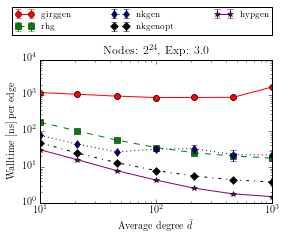

['girggen', 'rhg', 'nkgen', 'nkgenopt', 'hypgen']
results/plot_deg_gtime_n16777216_e30_abs.pgf


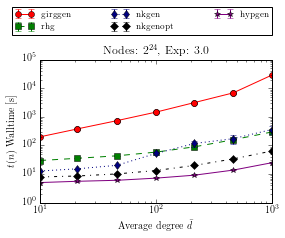

['girggen', 'rhg', 'nkgen', 'nkgenopt', 'hypgen']
results/plot_deg_compEdge_n16777216_e30_abs.pgf


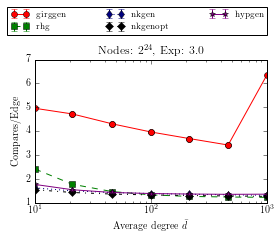

In [3]:
MIN_ITERATIONS=0
# Print runtime as function of average degree
def compareDegPlots(data, relative):
    latexFriendlyPlot(300)
    exps = data["exp"].unique()
    unodes = [2**24] # data["nodes"].unique()

    if relative:
        objectives = {
            "gtime": ("Walltime [ns] per edge ", 1e6 / 2**24, "deg", "log")
        }
    else:
        objectives = {
            "gtime": ("$t(n)$ Walltime [s]", 1e-3, "deg", "log"),
            "compEdge": ("Compares/Edge", 1, "deg", "linear")
        }

        
    for obj, (ylabel, yscale, xkey, yscale_type) in objectives.items():
        for (nodes, dexp) in itertools.product(unodes, exps):
            plot_data = data.loc[(data["exp"] == dexp)]

            fig = plt.figure(1)
            plt.cla()
            plt.clf()

            plt.axes([0.125,0.2,0.95-0.125,0.95-0.2])
            ax = plt.subplot()
            ax.set_xscale("log", nonposx='clip')
            ax.set_yscale(yscale_type, nonposy='clip')

            for (algo, ls, col, mark) in zip(sortAlgos(plot_data["algo"].unique()), linestyles, colors, markers):
                try:
                    grp = plot_data[plot_data["algo"] == algo].groupby("deg")
                    mask = grp.size() > MIN_ITERATIONS
                    if (not np.all(mask)):
                        print("Skip %d of %d groups as they include too few entries" % (np.sum(np.invert(mask)), len(mask)))

                    if not np.any(mask):
                        continue


                    if xkey == "deg":
                        xparam = grp["deg"].median()[mask]
                    else:
                        xparam = grp.median()[xkey][mask]


                    obj_mean = grp.mean()[obj][mask] * yscale
                    obj_err  = np.array(list(grp.std()[obj][mask] * yscale))

                    if relative:
                        obj_mean /= xparam
                        obj_err /= xparam

                    obj_err[np.isnan(obj_err)] = 0.0

                    plt.errorbar(xparam, obj_mean, yerr=obj_err, label=algoLabel(algo), 
                                 ls=ls, mfc=col, mec="#000000", color=col, marker=mark, markersize=6)
                except:
                    pass

            if (False and obj == "ressize"):
                plt.axhline(2**10 * 64)

            plt.title("Nodes: $2^{%d}$, Exp: %.1f" % ( np.log2(nodes), dexp/10.0))
            plt.xlabel(r"Average degree $\bar d$")
            plt.ylabel(ylabel)

            fn = 'results/plot_deg_%s_n%d_e%d_%s.%s' % (obj, nodes, dexp, "rel" if relative else "abs", PLOT_TYPE)
            print(fn)
            plt.legend(loc="best", ncol=3, mode="expand", bbox_to_anchor=(-0.14, 1.4, 1.16, 0))

            if SHOW_FIGURES:
                plt.show()
            else:
                plt.savefig(fn, transparnt=True, bbox_inches="tight")

compareDegPlots(data.loc[data["group"].map(lambda x: "degs24_" in x)], True)
compareDegPlots(data.loc[data["group"].map(lambda x: "degs24_" in x)], False)
compareDegPlots(data.loc[data["group"].map(lambda x: "dist_" in x)], False)

results/speedup_ressize_d10_e30.pgf


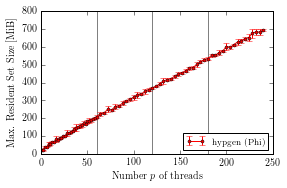

results/speedup_gtime_d10_e30.pgf


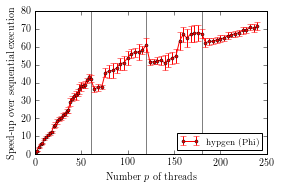

In [4]:
def speedupPlot(data, p=60):
    latexFriendlyPlot(300)
    
    exps = data["exp"].unique()
    exps = [30]
    objectives = {"gtime": ("Speed-up over sequential execution", 1e-3, True), "ressize": ("Max. Resident Set Size [MiB]", 2.0**-10, False)}
    
    for obj, (ylabel, yscale, relative) in objectives.items():
        for (deg, dexp) in itertools.product(data["deg"].unique(), exps):
            plot_data = data.loc[(data["deg"]==deg)&(data["exp"] == dexp)]
            
            fig = plt.figure(1)
            plt.clf()

            plt.axes([0.125,0.2,0.95-0.125,0.95-0.2])
            ax = plt.subplot()
            #ax.set_xscale("log", nonposx='clip')
            #ax.set_yscale("log", nonposy='clip')

            for (algo, ls, col, mark) in zip(sorted(plot_data["algo"].unique())[::-1], linestyles, colors, markers):
                try:
                    grp = plot_data[(plot_data["algo"] == algo)].groupby("worker")
                    obj_mean = grp.mean()[obj] * yscale
                    obj_err  = grp.std()[obj] * yscale
                    maxSegs = int(max(list(obj_mean.index)))

                    if relative:
                        base = obj_mean[1]
                        base_err = obj_err[1]
                        obj_err  = base_err / obj_mean + base / obj_mean**2 * obj_err
                        obj_mean = base / obj_mean
                    
                    ax.errorbar(list(obj_mean.index), list(obj_mean), list(obj_err), label=algoLabel(algo),
                                ls=ls, color=col, marker=mark, markersize=3)
                    for x in range(p, maxSegs, p):
                        ax.axvline(x, zorder=-1, color="#808080")
                    
                except:
                    pass

            plt.xlabel('Number $p$ of threads')
            plt.ylabel(ylabel)
            #plt.legend(loc="upper left")
            plt.legend(loc="lower right")
            fn = 'results/speedup_%s_d%d_e%d.pgf' % (obj, deg, dexp)
            print(fn)
            if SHOW_FIGURES:
                plt.show()
            else:
                plt.savefig(fn, transparent=True, bbox_inches="tight")

speedupPlot(data.loc[data["group"].map(lambda x: x in ["phi_str_scale"])])

In [5]:
def aggrGroup(group, key, scale=1.0):
    aggr = (group[key].mean())*scale
    std  = (group[key].std())*scale
    return (aggr, 0.0 if np.isnan(std) else std)

def latexAggrStd(aggr, std, scale=1.0):
    if std == 0.0:
        return r"$%0.1f$" % (aggr*scale)
    
    if std*scale > 10:
        return r"$%d \pm %d$" % (np.round(aggr*scale), np.round(std*scale))
    
    return r"$%0.1f \pm %.1f$" % (aggr*scale, std*scale)

def divWithError(aggr, std, div_aggr, div_std):
    return (aggr/div_aggr, std / div_aggr + aggr * div_aggr**-2 * div_std)

def writeRow(line):
    return "\t" + "& ".join([str(x).ljust(20) for x in line]) + r"\\\hline" + "\n"

def generateTable(data, deg, dexp, writeHeader=False, writeFooter=False):
    refAlgo = "hypgen"
    refRows = data[
        (data.algo == refAlgo) & (data.exp == dexp) & (data.deg == deg)
    ]
    
    params = r"$n {=} 2^{26}$, $\bar d {=} %d$, $\alpha {=} %.2f$, $R {=} %.1f$" % (
        deg, (dexp/10 - 1) / 2, refRows.R.median()
    )
    
    latex = ""
    
    if writeHeader:
        latex += r"\scalebox{0.63}{" + "\n"
        latex += r"\begin{tabular}{|l|" +"|r|r|"  +"|r|r|r|" +"|r|r|" +"|r|r|r|" + "}\n"
        latex += "\t" + r"\hline" + "\n"

    latex += "\t"
    latex +=      r"\multicolumn{3}{|l||}{"+params+"}"
    latex +=    r"& \multicolumn{3}{ c||}{in total}"
    latex +=    r"& \multicolumn{2}{ c||}{per edge}"
    latex +=    r"& \multicolumn{3}{ c| }{relative to \hypgen}"
    latex += r"\\\hline" + "\n"
    
    latex += writeRow([
        "Algo ", "$S$", "Degree",
        "Comp. [$10^8$]", "RSS [GB]", "Time [s]",
        "Comp.", "Time [ns]",
        "Comp.", "RSS", "Time"
    ])
    
    
    for algo in ["hypgen", "nkgen", "nkgenopt", "rhg", "girggen"]:
        if algo=="girggen" and dexp==30 and deg==1000:
            latex += writeRow([
                algoLabel(algo, True) + "$^\dagger$",
                1,
                "",
                
                "",
                "",
                "$\ge 10^5$",
                
                "",
                "",
                
                "",
                "",
                "$\ge 1150$"
            ])
            continue
        
        rows = data[(data.algo == algo) & (data.exp == dexp) & (data.deg == deg)]
        
        nodes, nodes_std = aggrGroup(rows, "nodes")
        edges, edges_std = aggrGroup(rows, "edges")
        edegs, edegs_std = aggrGroup(rows, "effDeg")
        gtime, gtime_std = aggrGroup(rows, "gtime")
        comps, comps_std = aggrGroup(rows, "compares")
        rsize, rsize_std = aggrGroup(rows, "ressize")

        line = [
            algoLabel(algo, True),
            len(rows.index),
#            latexAggrStd(nodes, nodes_std, 1e-6),
            latexAggrStd(edegs, edegs_std),
            
            latexAggrStd(comps, comps_std, 1e-8),
            latexAggrStd(rsize, rsize_std, 1 / 1024 / 1024),
            latexAggrStd(gtime, gtime_std, 1e-3),
            
            latexAggrStd(*divWithError(comps, comps_std, edges, edges_std)),
#            latexAggrStd(*divWithError(rsize, rsize_std, nodes, nodes_std), 1024),
            latexAggrStd(*divWithError(gtime, gtime_std, edges, edges_std), 1e6),
        ]
        
                                     
        if (algo == refAlgo):
            line += ["1"] * 3
        else:
            line += [
                latexAggrStd(*divWithError(comps, comps_std, *aggrGroup(refRows, "compares"))),
                latexAggrStd(*divWithError(rsize, rsize_std, *aggrGroup(refRows, "ressize"))),
                latexAggrStd(*divWithError(gtime, gtime_std, *aggrGroup(refRows, "gtime")))
            ]

        latex += writeRow(line)
    
    if writeFooter:
        latex += r"\end{tabular}}" + "\n\n"
    else:
        latex += "\n" + r"\multicolumn{11}{c}{\vspace{1.2em}}\\\hline" + "\n\n"
        
    return latex

tableData = data.loc[data["group"].map(lambda x: ("tab26" in x or "rhg" == x) and not "skipdist" in x)]
tableData = tableData[ (tableData.nodes > 2**26 * 0.9) & (tableData.nodes < 2**26 * 1.1) ]

latex = generateTable(tableData,   10, 21, writeHeader=True)
latex += generateTable(tableData,   10, 30)
latex += generateTable(tableData, 1000, 21)
latex += generateTable(tableData, 1000, 30, writeFooter=True)

print(latex)

with open("results/table_compare.tex", "w") as f:
    f.write(latex)


\scalebox{0.63}{
\begin{tabular}{|l||r|r||r|r|r||r|r||r|r|r|}
	\hline
	\multicolumn{3}{|l||}{$n {=} 2^{26}$, $\bar d {=} 10$, $\alpha {=} 0.55$, $R {=} 39.2$}& \multicolumn{3}{ c||}{in total}& \multicolumn{2}{ c||}{per edge}& \multicolumn{3}{ c| }{relative to \hypgen}\\\hline
	Algo                & $S$                 & Degree              & Comp. [$10^8$]      & RSS [GB]            & Time [s]            & Comp.               & Time [ns]           & Comp.               & RSS                 & Time                \\\hline
	\hypgen             & 6                   & $10.3 \pm 0.4$      & $7.5 \pm 0.2$       & $0.0 \pm 0.0$       & $11.8 \pm 0.1$      & $2.1 \pm 0.1$       & $34.0 \pm 1.4$      & 1                   & 1                   & 1                   \\\hline
	\nkgen              & 6                   & $9.8 \pm 0.7$       & $5.6 \pm 0.3$       & $4.6 \pm 0.3$       & $57.1 \pm 3.0$      & $1.7 \pm 0.2$       & $173 \pm 22$        & $0.8 \pm 0.1$       & $290 \pm 22$        & $4